<a href="https://colab.research.google.com/github/sarnavadatta/Predictive-Modelling/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project implements a machine learning model for detecting fraudulent credit card transactions using Python. The dataset used is obtained from Kaggle's "Credit Card Fraud Detection" dataset. The model employs XGBoost and LightGBM classifiers, with oversampling via SMOTE to handle class imbalance.

**Downloading the Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:02<00:00, 33.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


**Data Processing**

In [ ]:
import pandas as pd
import os

file_path = os.path.join(path, 'creditcard.csv')

if os.path.exists(file_path):
    try:
      data = pd.read_csv(file_path)
    except Exception as e:
      print(f"An error occurred while reading the file: {e}")
else:
    print(f"File not found at {file_path}")

df = pd.DataFrame(data)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Importing Required Libraries**

In [ ]:
import cv2
import time
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score, classification_report
from sklearn.metrics import recall_score, average_precision_score, auc

import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb

**Exploratory Data Analysis**

Checking for Missing Values

In [ ]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Checking for Class Distribution

In [ ]:
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


**Feature Scaling**

In [ ]:
# Normalize the Amount and Time features:
from sklearn.preprocessing import StandardScaler

df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

**Splitting the Data**

In [ ]:
# Split the data into training and testing sets:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Training data count of 0={}, count of 1={}".format(sum(y_train==0), sum(y_train==1)))
print("Testing data count of 0={}, count of 1={}".format(sum(y_test==0), sum(y_test==1)))

Training data count of 0=227451, count of 1=394
Testing data count of 0=56864, count of 1=98


**Handling Class Imbalance with SMOTE**

In [ ]:
smote = SMOTE(random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [ ]:
len(X_train_resample), len(y_train_resample)

(454902, 454902)

**Train model using XGBoost**

In [ ]:
# Train the model with XGBoost
model = xgb.XGBClassifier(
    scale_pos_weight=(len(y_train_resample) - sum(y_train_resample)) / sum(y_train_resample),  # Handle imbalance
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
model.fit(X_train_resample, y_train_resample)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.28      0.89      0.43        98

    accuracy                           1.00     56962
   macro avg       0.64      0.94      0.71     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9419255251340829


**Visualizing XGBoost Model Performance**

In [ ]:
# Model predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.28      0.89      0.43        98

    accuracy                           1.00     56962
   macro avg       0.64      0.94      0.71     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9878


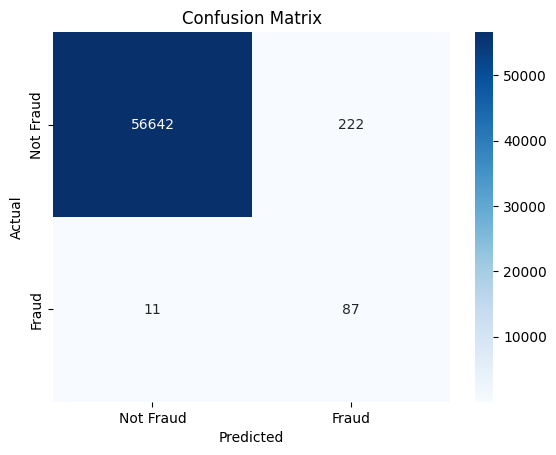

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Train model using LightGBM**

In [ ]:
LGBM_Classifier = lgb.LGBMClassifier(objective='binary', random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rs_parameters = {
    'lgbmclassifier__learning_rate': [0.005,0.01,0.001],
    'lgbmclassifier__n_estimators': [60,80,100],
    'lgbmclassifier__num_leaves': [6,8,12,16]
    }
Grid_LGBM = GridSearchCV(LGBM_Classifier,
                         param_grid=rs_parameters,
                         cv=kf,
                         scoring='roc_auc',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
Grid_LGBM.fit(X_train_resample, y_train_resample)

Best_estimator = Grid_LGBM.best_estimator_
y_pred = Best_estimator.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__n_estimators
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__n_estimators
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__num_leaves
[LightGBM] [Warni

**Visualizing LghtGBM Model Performance**

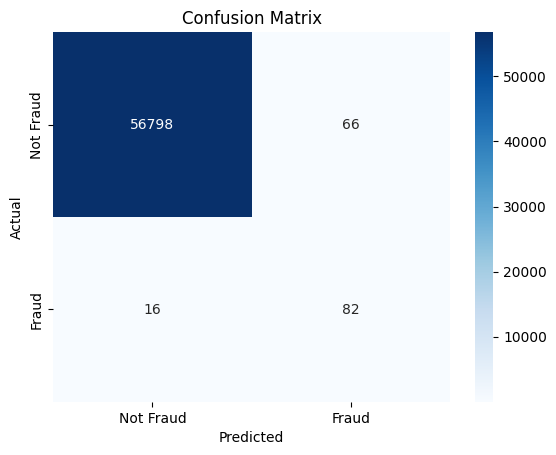

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()